In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [2]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [3]:
# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

In [4]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

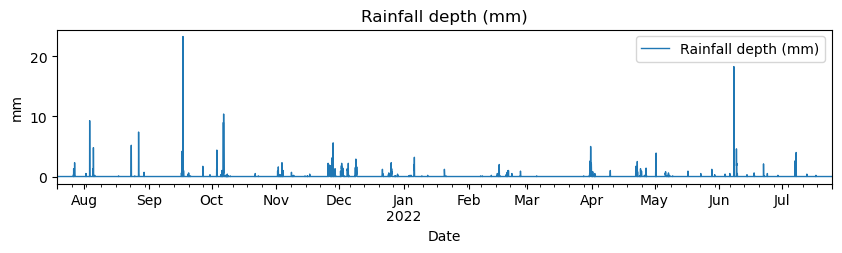

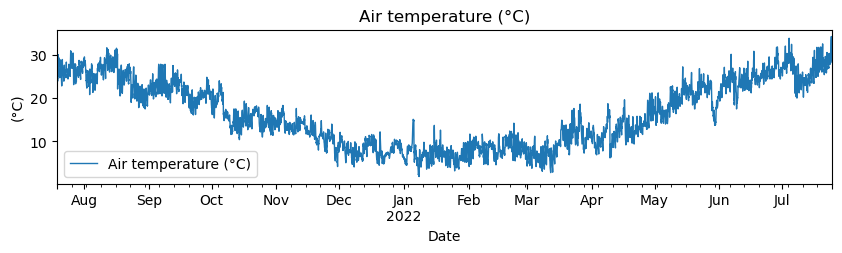

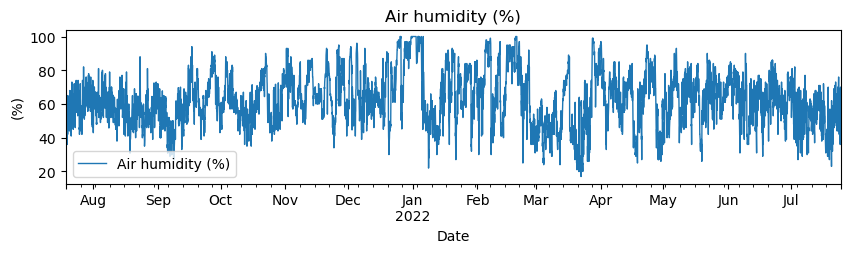

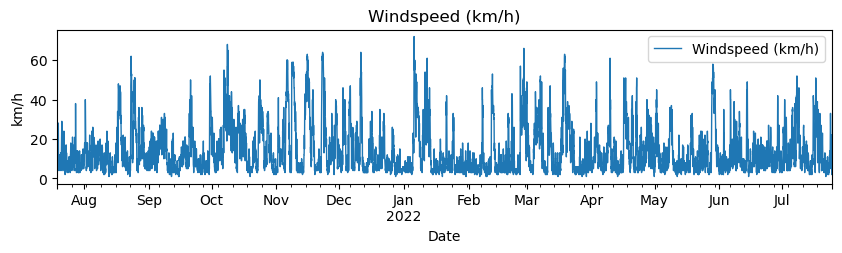

In [5]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2021-07-19'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

## add weekened and holidays as exogenous variable (one hot encoded)
# tseriesX_df['weekend (0/1)'] = 0
# tseriesX_df[0:24] = 1
# tseriesX_df[144:192] = 1
# tseriesX_df[312:360] = 1

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# fill missing values with interpolation technique
#tseriesX_df.interpolate(limit_direction='both',inplace=True)

## visualize weather data

# RAINFALL
var = 'Rainfall depth (mm)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'Air temperature (°C)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'Air humidity (%)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'Windspeed (km/h)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91537D+00    |proj g|=  2.00852D-01


 This problem is unconstrained.



At iterate    5    f=  1.83975D+00    |proj g|=  8.28996D-02

At iterate   10    f=  1.80168D+00    |proj g|=  6.50347D-02

At iterate   15    f=  1.78468D+00    |proj g|=  7.02720D-02

At iterate   20    f=  1.77858D+00    |proj g|=  2.87667D-02

At iterate   25    f=  1.77556D+00    |proj g|=  8.51977D-03

At iterate   30    f=  1.77456D+00    |proj g|=  1.23735D-02

At iterate   35    f=  1.77426D+00    |proj g|=  1.34576D-02

At iterate   40    f=  1.77363D+00    |proj g|=  1.75214D-02

At iterate   45    f=  1.77290D+00    |proj g|=  3.66933D-02

At iterate   50    f=  1.77242D+00    |proj g|=  1.18237D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

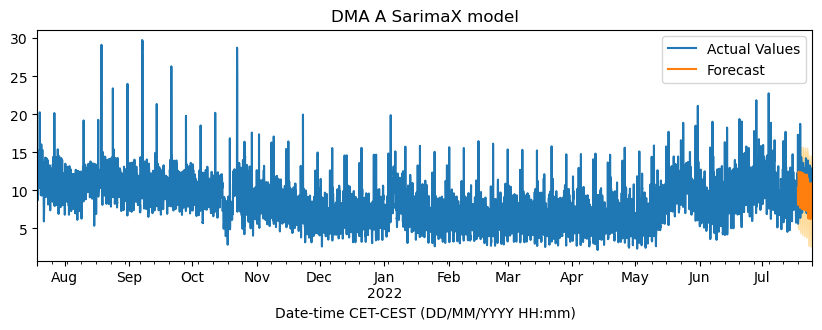

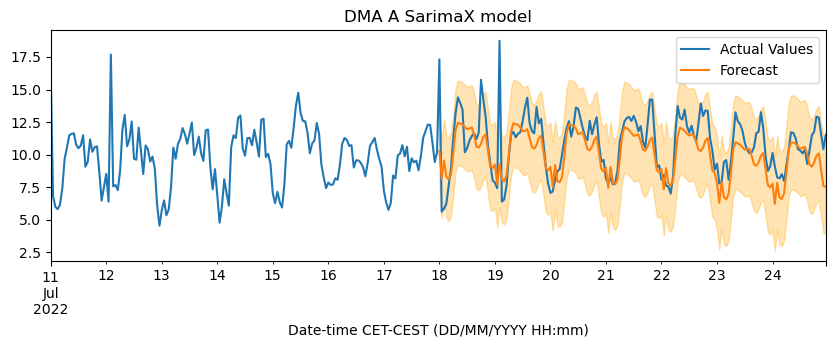

Performance indicators
DMA A SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.72            7.03             1.25           10.00 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.25            8.61             2.48           14.34 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12986D+00    |proj g|=  1.08735D+00


 This problem is unconstrained.



At iterate    5    f=  8.61351D-01    |proj g|=  5.72874D-01

At iterate   10    f=  7.23129D-01    |proj g|=  1.19607D+00

At iterate   15    f=  7.08770D-01    |proj g|=  9.05531D-01

At iterate   20    f=  6.75739D-01    |proj g|=  1.07869D-01

At iterate   25    f=  6.66124D-01    |proj g|=  1.09555D-01

At iterate   30    f=  6.65448D-01    |proj g|=  2.27050D-02

At iterate   35    f=  6.65293D-01    |proj g|=  1.13367D-02

At iterate   40    f=  6.65284D-01    |proj g|=  2.82761D-03

At iterate   45    f=  6.65266D-01    |proj g|=  9.45638D-03

At iterate   50    f=  6.65127D-01    |proj g|=  8.69475D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

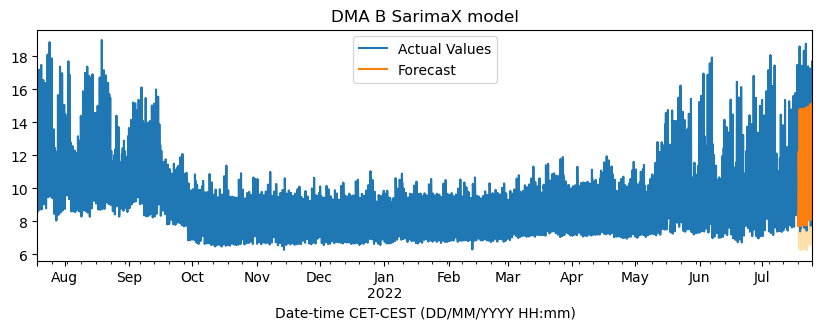

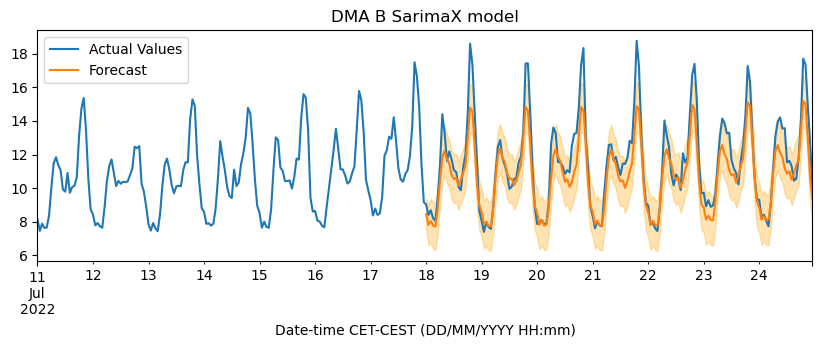

Performance indicators
DMA B SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.00            3.80             0.86           5.66 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.62            9.29             2.72           14.64 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97861D-01    |proj g|=  4.85563D-01

At iterate    5    f=  4.80210D-01    |proj g|=  3.87175D-01

At iterate   10    f=  4.59670D-01    |proj g|=  9.56319D-01

At iterate   15    f=  4.22662D-01    |proj g|=  1.04056D-01

At iterate   20    f=  4.16466D-01    |proj g|=  3.63378D-02

At iterate   25    f=  4.14962D-01    |proj g|=  3.06291D-02

At iterate   30    f=  4.14640D-01    |proj g|=  2.44772D-02

At iterate   35    f=  4.14466D-01    |proj g|=  1.21457D-02

At iterate   40    f=  4.14298D-01    |proj g|=  8.29280D-03

At iterate   45    f=  4.14106D-01    |proj g|=  1.27921D-02

At iterate   50    f=  4.13979D-01    |proj g|=  2.05504D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

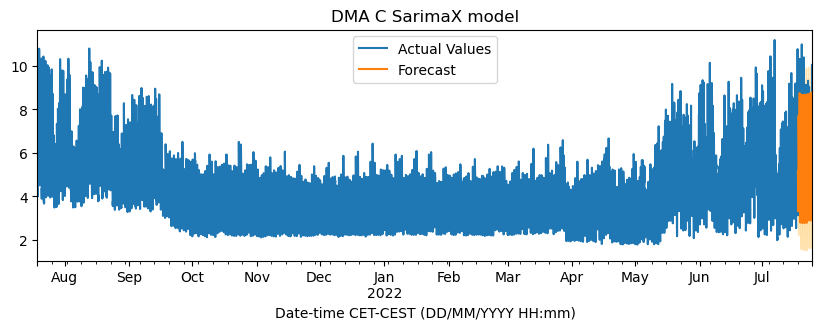

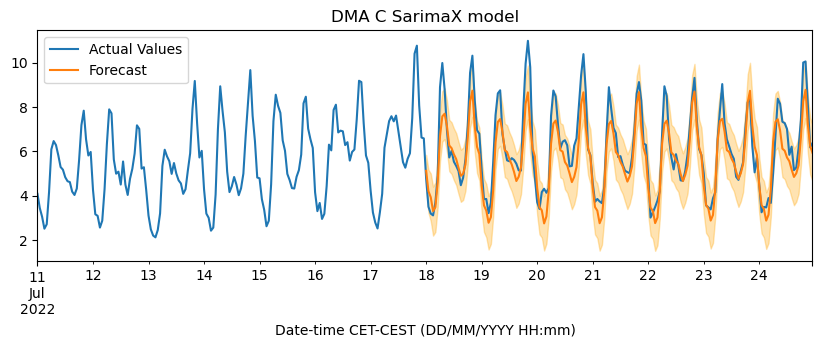

Performance indicators
DMA C SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.70            2.41             0.62           3.73 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.22            5.98             2.01           10.21 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42290D+00    |proj g|=  9.55041D-02

At iterate    5    f=  2.33819D+00    |proj g|=  1.42754D-01

At iterate   10    f=  2.32608D+00    |proj g|=  3.71994D-02

At iterate   15    f=  2.31739D+00    |proj g|=  5.83308D-03

At iterate   20    f=  2.31727D+00    |proj g|=  2.85563D-03

At iterate   25    f=  2.31705D+00    |proj g|=  5.86236D-03

At iterate   30    f=  2.31694D+00    |proj g|=  2.63553D-03

At iterate   35    f=  2.31677D+00    |proj g|=  3.37008D-03

At iterate   40    f=  2.31612D+00    |proj g|=  3.20821D-02

At iterate   45    f=  2.31431D+00    |proj g|=  6.87935D-03

At iterate   50    f=  2.31336D+00    |proj g|=  1.67591D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

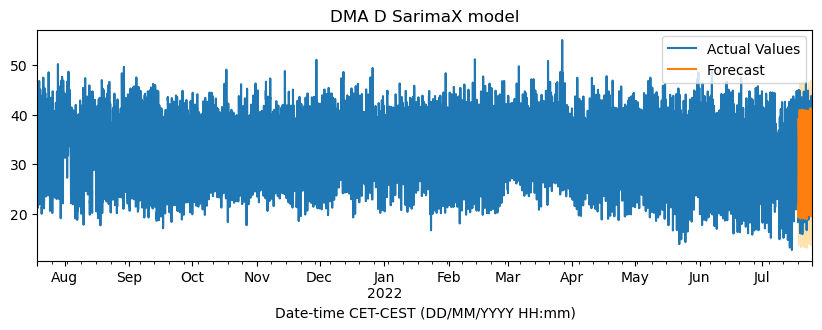

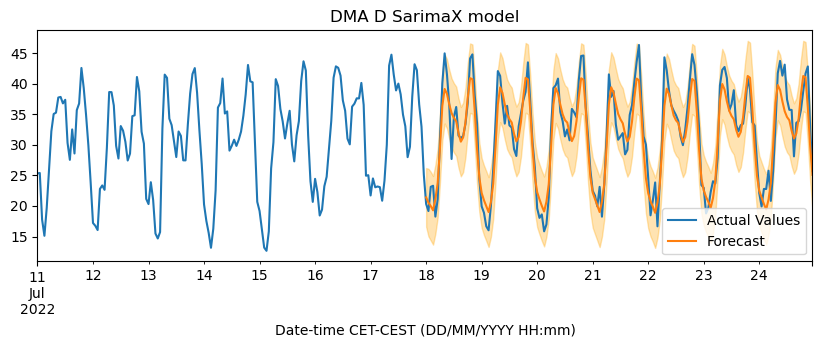

Performance indicators
DMA D SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.33            7.52             2.33           12.18 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
6.76            15.00             6.45           28.22 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05202D+00    |proj g|=  1.28128D+00


 This problem is unconstrained.



At iterate    5    f=  2.50963D+00    |proj g|=  7.24567D-02

At iterate   10    f=  2.42636D+00    |proj g|=  3.70147D-02

At iterate   15    f=  2.41923D+00    |proj g|=  2.26479D-02

At iterate   20    f=  2.41832D+00    |proj g|=  2.04334D-03

At iterate   25    f=  2.41829D+00    |proj g|=  2.78698D-03

At iterate   30    f=  2.41827D+00    |proj g|=  4.65871D-03

At iterate   35    f=  2.41824D+00    |proj g|=  3.82055D-04

At iterate   40    f=  2.41824D+00    |proj g|=  3.81256D-04

At iterate   45    f=  2.41824D+00    |proj g|=  1.96113D-04

At iterate   50    f=  2.41824D+00    |proj g|=  5.59712D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

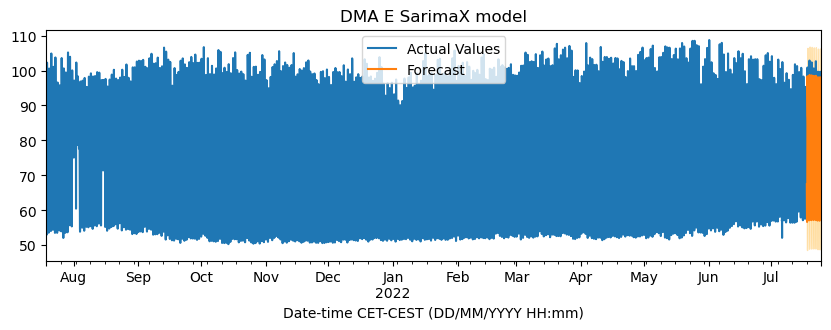

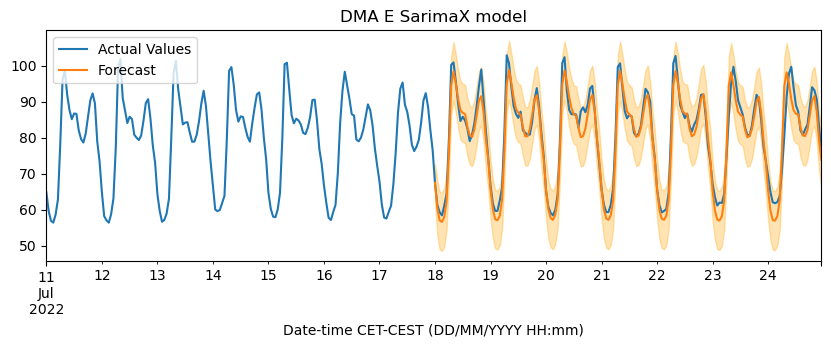

Performance indicators
DMA E SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.26            7.40             2.37           12.02 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
11.87            23.93             11.51           47.31 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51279D+00    |proj g|=  2.75042D-01


 This problem is unconstrained.



At iterate    5    f=  1.45959D+00    |proj g|=  9.35805D-02

At iterate   10    f=  1.42278D+00    |proj g|=  8.15628D-02

At iterate   15    f=  1.41983D+00    |proj g|=  2.34246D-02

At iterate   20    f=  1.41964D+00    |proj g|=  8.37437D-03

At iterate   25    f=  1.41937D+00    |proj g|=  1.66849D-02

At iterate   30    f=  1.41906D+00    |proj g|=  1.06535D-02

At iterate   35    f=  1.41864D+00    |proj g|=  3.94708D-02

At iterate   40    f=  1.41822D+00    |proj g|=  2.88094D-02

At iterate   45    f=  1.41805D+00    |proj g|=  8.29324D-03

At iterate   50    f=  1.41791D+00    |proj g|=  4.67008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

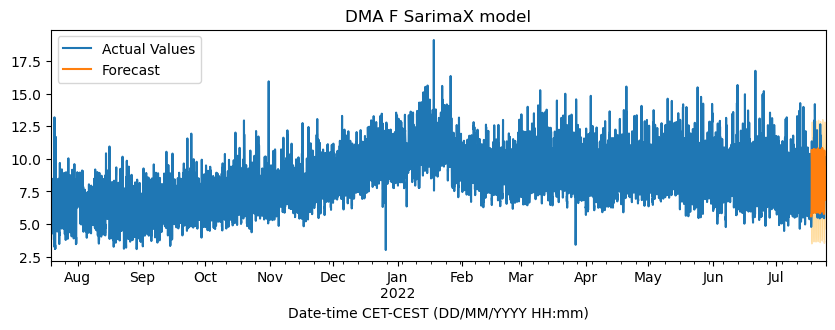

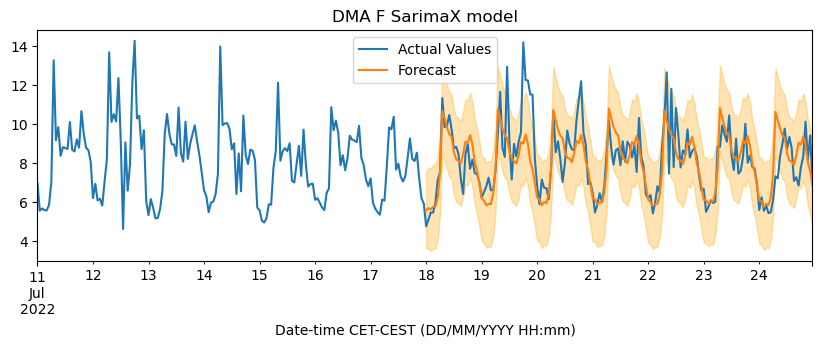

Performance indicators
DMA F SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.57            2.06             0.92           3.55 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.48            3.63             1.38           6.49 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11260D+00    |proj g|=  7.75381D-01

At iterate    5    f=  1.86330D+00    |proj g|=  1.19041D-01

At iterate   10    f=  1.80070D+00    |proj g|=  9.58102D-02

At iterate   15    f=  1.75829D+00    |proj g|=  2.01320D-02

At iterate   20    f=  1.75729D+00    |proj g|=  9.45106D-04

At iterate   25    f=  1.75729D+00    |proj g|=  9.58783D-04

At iterate   30    f=  1.75728D+00    |proj g|=  6.07809D-04

At iterate   35    f=  1.75727D+00    |proj g|=  7.79911D-04

At iterate   40    f=  1.75727D+00    |proj g|=  6.70085D-04

At iterate   45    f=  1.75724D+00    |proj g|=  9.12858D-03

At iterate   50    f=  1.75712D+00    |proj g|=  3.48091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

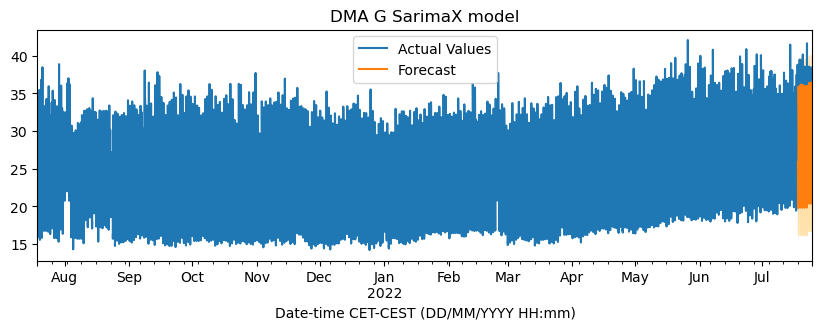

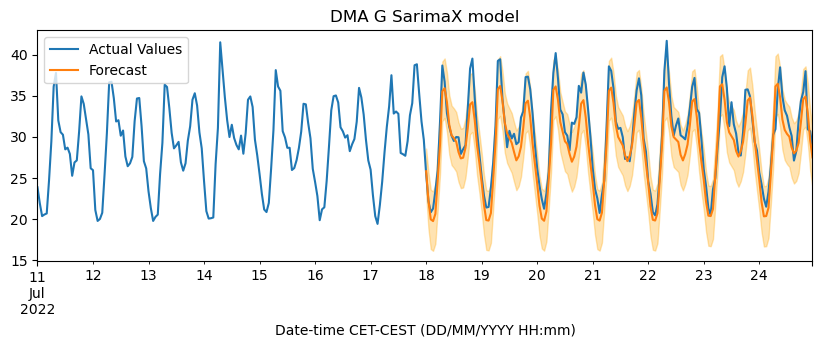

Performance indicators
DMA G SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.55            5.30             1.91           8.76 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
5.95            14.41             6.27           26.64 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89366D+00    |proj g|=  9.26283D-01


 This problem is unconstrained.



At iterate    5    f=  1.59309D+00    |proj g|=  1.33123D-01

At iterate   10    f=  1.53372D+00    |proj g|=  2.23919D-01

At iterate   15    f=  1.48466D+00    |proj g|=  8.20373D-02

At iterate   20    f=  1.48322D+00    |proj g|=  4.78963D-03

At iterate   25    f=  1.48280D+00    |proj g|=  1.25749D-02

At iterate   30    f=  1.48205D+00    |proj g|=  9.73300D-03

At iterate   35    f=  1.48171D+00    |proj g|=  6.74859D-03

At iterate   40    f=  1.48163D+00    |proj g|=  1.14218D-02

At iterate   45    f=  1.48147D+00    |proj g|=  1.98335D-02

At iterate   50    f=  1.48121D+00    |proj g|=  5.76931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

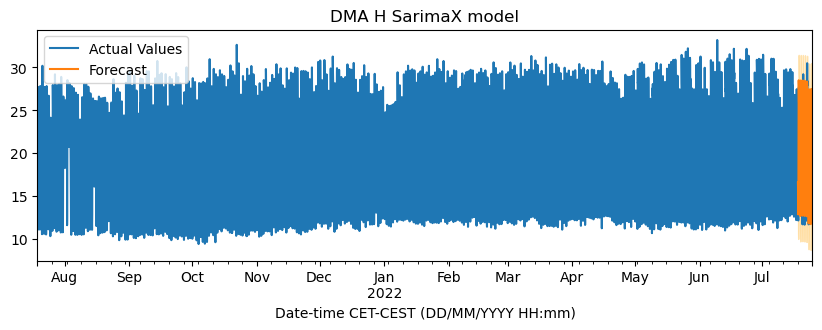

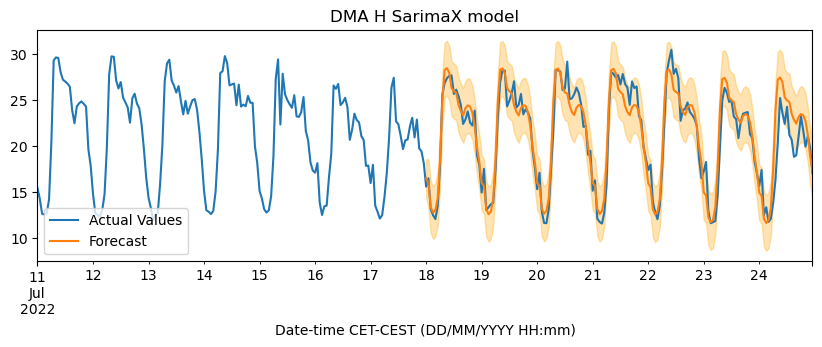

Performance indicators
DMA H SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.86            1.79             1.32           3.97 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.70            8.55             4.59           17.84 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07094D+00    |proj g|=  6.20956D-01


 This problem is unconstrained.



At iterate    5    f=  1.86439D+00    |proj g|=  2.21415D-01

At iterate   10    f=  1.79882D+00    |proj g|=  9.06699D-02

At iterate   15    f=  1.76437D+00    |proj g|=  8.21895D-02

At iterate   20    f=  1.75966D+00    |proj g|=  2.47825D-02

At iterate   25    f=  1.75874D+00    |proj g|=  6.47632D-03

At iterate   30    f=  1.75717D+00    |proj g|=  1.96396D-02

At iterate   35    f=  1.75438D+00    |proj g|=  1.60003D-02

At iterate   40    f=  1.75390D+00    |proj g|=  8.49144D-03

At iterate   45    f=  1.75372D+00    |proj g|=  1.78597D-02

At iterate   50    f=  1.75367D+00    |proj g|=  1.31859D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

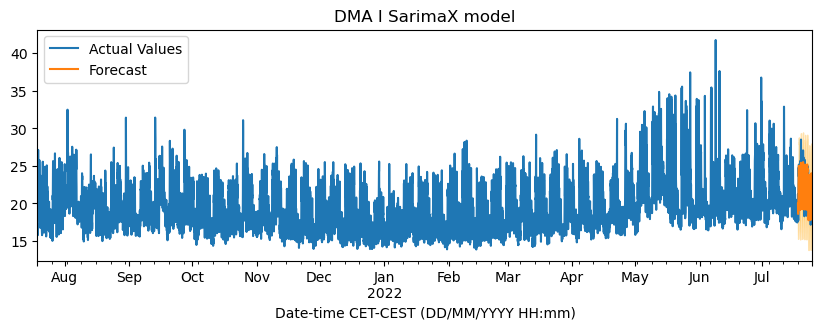

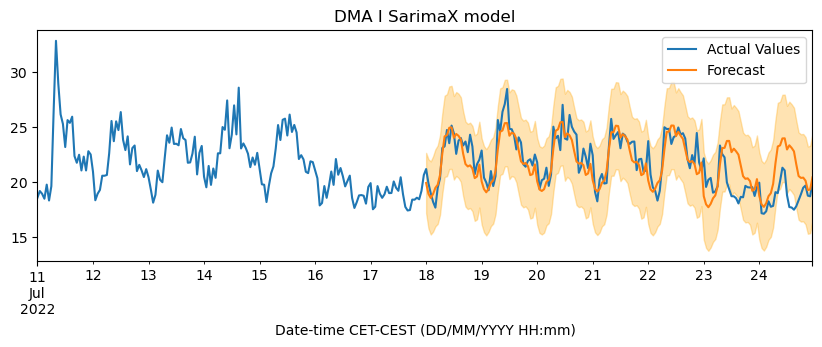

Performance indicators
DMA I SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.95            2.78             1.36           5.09 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.94            5.60             2.49           11.04 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90852D+00    |proj g|=  1.62515D-01


 This problem is unconstrained.



At iterate    5    f=  1.83698D+00    |proj g|=  1.66143D-01

At iterate   10    f=  1.79215D+00    |proj g|=  1.04249D-01

At iterate   15    f=  1.77723D+00    |proj g|=  2.27771D-02

At iterate   20    f=  1.77669D+00    |proj g|=  1.42651D-02

At iterate   25    f=  1.77499D+00    |proj g|=  1.14355D-02

At iterate   30    f=  1.77375D+00    |proj g|=  2.37311D-02

At iterate   35    f=  1.77290D+00    |proj g|=  7.47200D-03

At iterate   40    f=  1.77286D+00    |proj g|=  1.05343D-03

At iterate   45    f=  1.77284D+00    |proj g|=  2.45956D-03

At iterate   50    f=  1.77278D+00    |proj g|=  2.54988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

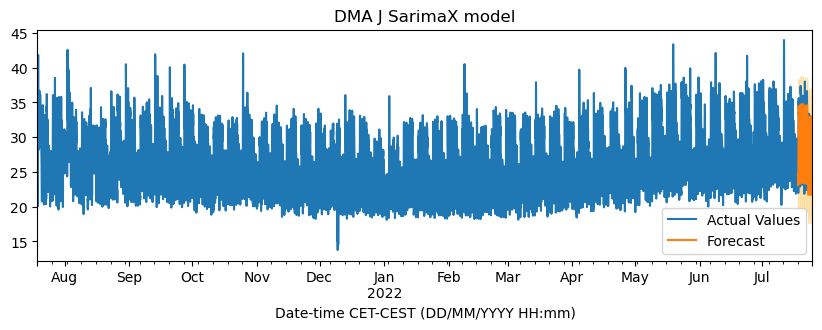

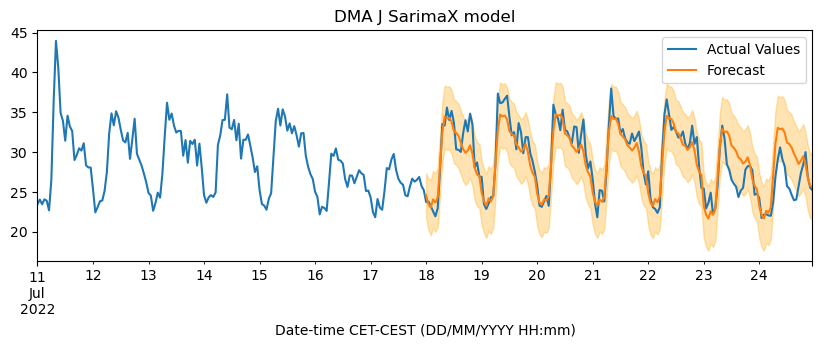

Performance indicators
DMA J SarimaX 52-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.48            4.09             1.54           7.10 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.97            9.16             4.03           18.17 



In [6]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    #tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    # demand time series
    y = tseries_df
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    # exogenous variables time series
    X = tseriesX_df
    X_train, X_test = temporal_train_test_split(X, test_size=168)

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean')
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.

    model = SARIMAX(y_train, exog=X_train, order=(4,0,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    # print(model_fit.summary())

    y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

    # plot forecast and full time series length
    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    # plot forecast and last two weeks of time series
    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 52-Weeks',return_df=1)
    results_df = pd.concat([results_df, df])
    print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [7]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX 52-Weeks,1.720,7.034,1.246,10.000
DMA B SarimaX 52-Weeks,0.995,3.805,0.860,5.660
DMA C SarimaX 52-Weeks,0.704,2.406,0.621,3.732
DMA D SarimaX 52-Weeks,2.333,7.520,2.329,12.183
DMA E SarimaX 52-Weeks,2.256,7.398,2.371,12.024
DMA F SarimaX 52-Weeks,0.568,2.057,0.922,3.547
DMA G SarimaX 52-Weeks,1.550,5.298,1.914,8.762
DMA H SarimaX 52-Weeks,0.861,1.786,1.322,3.969
DMA I SarimaX 52-Weeks,0.950,2.783,1.357,5.090
DMA J SarimaX 52-Weeks,1.479,4.089,1.536,7.104


In [8]:
print(f"{results_df['Total'].sum() :.2f}")

72.07


In [9]:
print(f"{results_df.drop('DMA E SarimaX 52-Weeks')['Total'].sum() :.2f}")

60.05
